In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, LSTM,Embedding
from tensorflow.keras.layers import LSTM,GRU
from joblib import dump, load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from preprocessing import TimeSeriesPreprocessor



%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
# hyper params
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SEQ_LEN = 14
PRED_LEN = 1

BATCH_SIZE = 16
DROPOUT = 0.2
model_path = os.path.join(os.getcwd(), 'model')
data_path = os.path.join(os.getcwd(), 'data')
result_path = os.path.join(os.getcwd(), 'result')

try:
    os.makedirs(model_path)
    os.makedirs(result_path)    

except FileExistsError:
    pass

### Data Preprocess

- 결측치 - 전일 값으로 대체

In [3]:
# 국제
dataset1 = pd.read_csv(os.path.join(data_path, "국제_원유가격.csv"), parse_dates=['기간'], encoding='utf-8')
dataset1 = dataset1.sort_values('기간')

# 국내
dataset2 = pd.read_csv(os.path.join(data_path, "주유소_평균판매가격.csv"), parse_dates=['구분'], encoding='utf-8')
dataset2 = dataset2.sort_values('구분')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


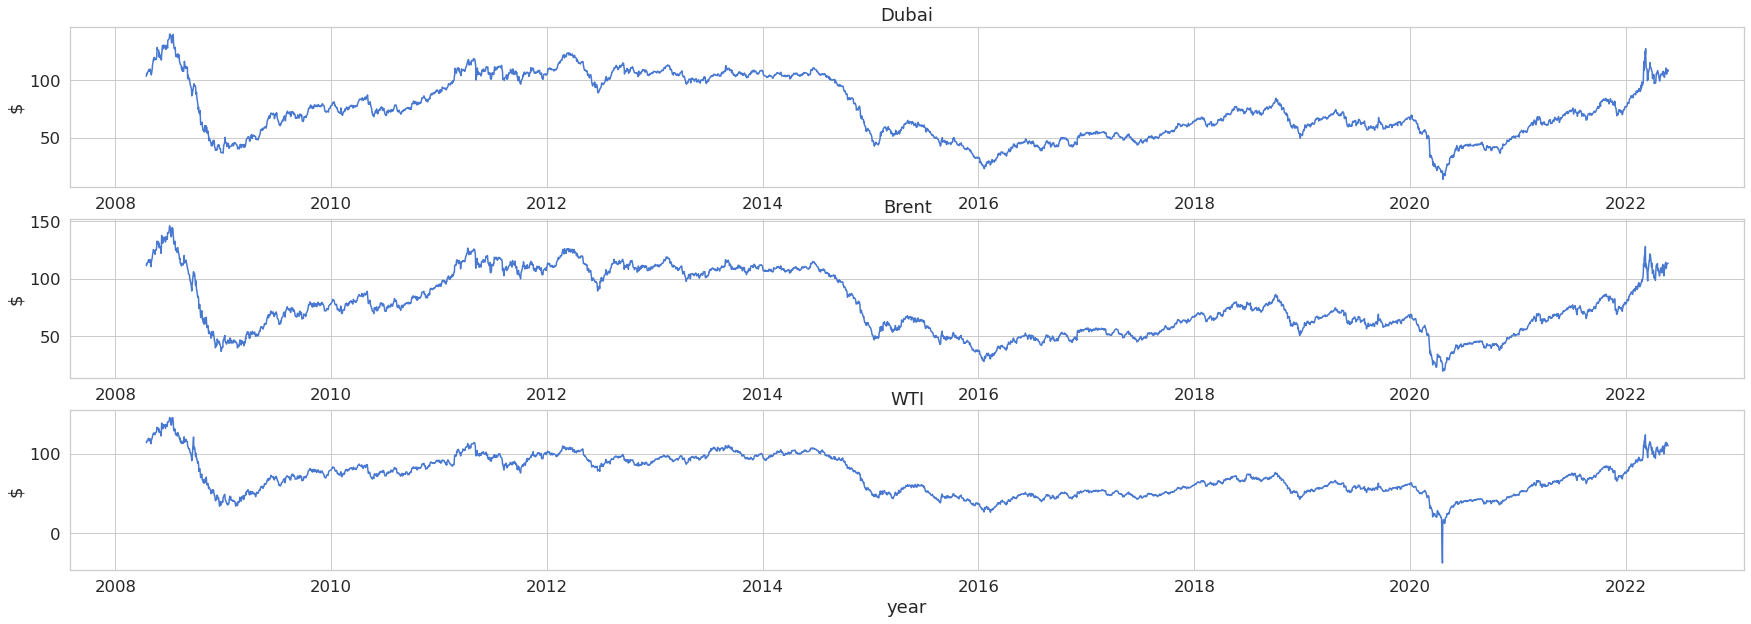

In [4]:
# 국제
plt.figure(figsize=(30, 10))
for i, c in enumerate(dataset1.columns[1:]):
    plt.subplot(3, 1, i+1)
    plt.plot(dataset1.iloc[:, 0], dataset1.iloc[:, i+1], label = c)
    plt.title(c)
    plt.xlabel('year')
    plt.ylabel('$')
plt.show()

/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55064 (\N{HANGUL SYLLABLE HWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fig.ca

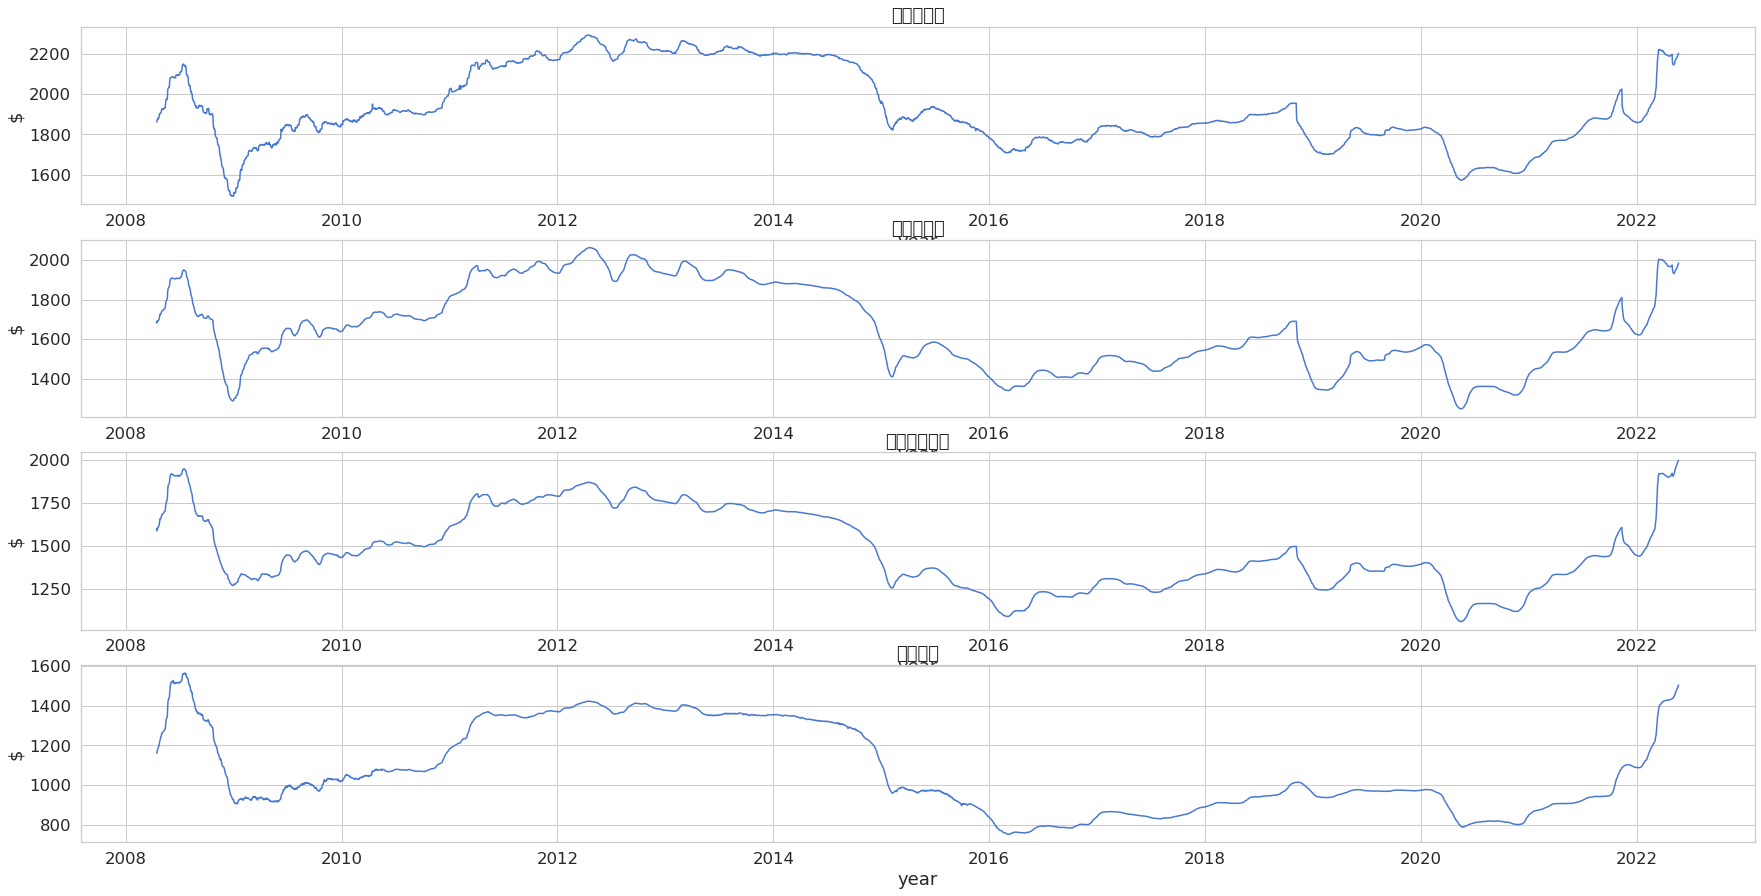

In [5]:
# 국내
plt.figure(figsize=(30, 15))
for i, c in enumerate(dataset2.columns[1:]):
    plt.subplot(4, 1, i+1)
    plt.plot(dataset2.iloc[:, 0], dataset2.iloc[:, i+1], label = c)
    plt.title(c)
    plt.xlabel('year')
    plt.ylabel('$')
plt.show()

In [5]:
total_dataset = pd.merge(left=dataset1, right=dataset2, left_on='기간', right_on='구분')
del total_dataset['구분']
total_dataset

,기간,Dubai,Brent,WTI,고급휘발유,보통휘발유,자동차용경유,실내등유
0,2008-04-15,103.66,111.31,113.79,1861.80,1681.33,1585.35,1159.41
1,2008-04-16,105.16,112.66,114.93,1871.39,1692.15,1600.81,1168.47
2,2008-04-17,106.39,112.43,114.86,1874.54,1686.56,1594.53,1174.24
3,2008-04-18,105.83,113.92,116.69,1877.81,1689.68,1602.15,1179.31
4,2008-04-21,107.96,114.43,117.48,1881.82,1695.54,1610.82,1191.62
...,...,...,...,...,...,...,...,...
3637,2022-05-16,106.65,114.24,114.20,2177.84,1958.73,1970.51,1481.83
3638,2022-05-17,110.88,111.93,112.40,2183.42,1963.26,1976.49,1485.38
3639,2022-05-18,109.79,109.11,109.59,2185.95,1967.33,1981.61,1489.18
3640,2022-05-19,105.52,112.04,112.21,2191.74,1972.11,1986.76,1493.57


In [6]:
total_dataset.corr() # Brent price - 가장 큰 관련

,Dubai,Brent,WTI,고급휘발유,보통휘발유,자동차용경유,실내등유
Dubai,1.000000,0.996780,0.973240,0.892202,0.939587,0.958057,0.929514
Brent,0.996780,1.000000,0.975489,0.895856,0.940608,0.958887,0.932900
WTI,0.973240,0.975489,1.000000,0.837694,0.902133,0.930084,0.900427
고급휘발유,0.892202,0.895856,0.837694,1.000000,0.959203,0.923680,0.909001
보통휘발유,0.939587,0.940608,0.902133,0.959203,1.000000,0.977514,0.939155
자동차용경유,0.958057,0.958887,0.930084,0.923680,0.977514,1.000000,0.972848
실내등유,0.929514,0.932900,0.900427,0.909001,0.939155,0.972848,1.000000


brent oil 설명: https://bibeom.com/2020/03/08/%EA%B5%AD%EC%A0%9C%EC%9C%A0%EA%B0%80%EC%97%90-%ED%88%AC%EC%9E%90%ED%95%98%EB%8A%94-3%EA%B0%80%EC%A7%80-%EB%B0%A9%EB%B2%95%EB%B8%8C%EB%A0%8C%ED%8A%B8%EC%9C%A0-wti%ED%85%8D%EC%82%AC%EC%8A%A4%EC%9C%A0/

#

In [7]:
df1 = total_dataset.loc[:,['Brent', '자동차용경유']]

In [8]:
df1

,Brent,자동차용경유
0,111.31,1585.35
1,112.66,1600.81
2,112.43,1594.53
3,113.92,1602.15
4,114.43,1610.82
...,...,...
3637,114.24,1970.51
3638,111.93,1976.49
3639,109.11,1981.61
3640,112.04,1986.76


In [9]:
# scaling data
scaler1 = MinMaxScaler()
scaled_df1 = scaler1.fit_transform(df1)

In [23]:
def to_sequences(data, seq_len, pred_len):
    x_train = []
    y_train = []

    for i in range(seq_len, len(data) - pred_len + 1):
        x_train.append(data[i - seq_len: i, 0:])
        y_train.append(data[i + pred_len - 1: i + pred_len, 1])

    return np.array(x_train), np.array(y_train)

def preprocess(data_raw, seq_len, pred_len, train_split):

    x_data, y_data = to_sequences(data_raw, seq_len, pred_len)
    num_train = int(train_split * x_data.shape[0])

    X_train = x_data[:num_train, :]
    y_train = y_data[:num_train, :]

    X_test = x_data[num_train:, :]
    y_test = y_data[num_train:, :]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_df1, SEQ_LEN, PRED_LEN, train_split = 0.95)
print("train data shape: ",[X_train.shape, y_train.shape])
print("test data shape: ", [X_test.shape, y_test.shape])

train data shape:  [(3446, 14, 2), (3446, 1)]
test data shape:  [(182, 14, 2), (182, 1)]


In [24]:
X_train

array([[[0.72568047, 0.564876  ],
        [0.73633136, 0.58145971],
        [0.73451677, 0.57472325],
        ...,
        [0.72607495, 0.6491676 ],
        [0.71928994, 0.65917575],
        [0.7513215 , 0.66451772]],

       [[0.73633136, 0.58145971],
        [0.73451677, 0.57472325],
        [0.74627219, 0.58289711],
        ...,
        [0.71928994, 0.65917575],
        [0.7513215 , 0.66451772],
        [0.77838264, 0.6711791 ]],

       [[0.73451677, 0.57472325],
        [0.74627219, 0.58289711],
        [0.75029586, 0.59219729],
        ...,
        [0.7513215 , 0.66451772],
        [0.77838264, 0.6711791 ],
        [0.79668639, 0.67256286]],

       ...,

       [[0.39589744, 0.41112804],
        [0.39211045, 0.41099931],
        [0.38579882, 0.41067751],
        ...,
        [0.42335306, 0.4068802 ],
        [0.41230769, 0.40653694],
        [0.42366864, 0.40633313]],

       [[0.39211045, 0.41099931],
        [0.38579882, 0.41067751],
        [0.37175542, 0.41004462],
        .

In [25]:
def train_model(X_train, y_train, BATCH_SIZE):
    model = keras.Sequential()

    #################################
    model.add(GRU(64,return_sequences=True,input_shape=(X_train.shape[1],2)))
   
    model.add(GRU(32,return_sequences=True))
    model.add(Dropout(rate=DROPOUT))
    
    model.add(GRU(16,return_sequences=False))
    
    model.add(Dense(y_train.shape[1]))

    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )
    ################################
    
    model.summary()
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs=50, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        validation_split=0.1
    )

    return model, history

model, history = train_model(X_train, y_train, BATCH_SIZE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 14, 64)            13056     
                                                                 
 gru_4 (GRU)                 (None, 14, 32)            9408      
                                                                 
 dropout_1 (Dropout)         (None, 14, 32)            0         
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,881
Trainable params: 24,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2022-06-07 13:07:16.825333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:17.111992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:17.154454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:17.197902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:17.251287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  3/194 [..............................] - ETA: 4s - loss: 0.6679  

2022-06-07 13:07:17.318435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:17.383493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - ETA: 0s - loss: 0.0196

2022-06-07 13:07:21.705123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:21.800624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:21.836418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-07 13:07:21.872638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - 6s 24ms/step - loss: 0.0196 - val_loss: 0.0062
Epoch 2/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 3/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 4/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0032 - val_loss: 0.0079
Epoch 5/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 6/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 7/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 8/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0021 - val_loss: 0.0064
Epoch 9/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 10/50
194/194 [==============================] - 4s 22ms/step - loss: 0.0018 - val_loss: 0.0048


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 14, 64)            13056     
                                                                 
 gru_4 (GRU)                 (None, 14, 32)            9408      
                                                                 
 dropout_1 (Dropout)         (None, 14, 32)            0         
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,881
Trainable params: 24,881
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 10ms/step - loss: 0.0065


0.006517959292978048

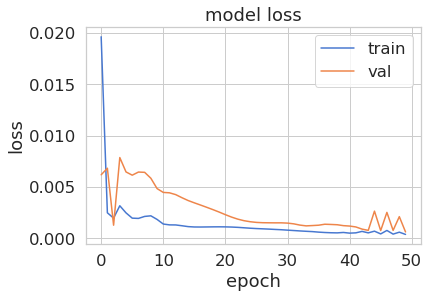

In [31]:
# Convergence of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [32]:
y_total.shape

(3628, 1)

In [33]:
X_total

array([[0.72568047, 0.73633136, 0.73451677, ..., 0.72607495, 0.71928994,
        0.7513215 ],
       [0.73633136, 0.73451677, 0.74627219, ..., 0.71928994, 0.7513215 ,
        0.77838264],
       [0.73451677, 0.74627219, 0.75029586, ..., 0.7513215 , 0.77838264,
        0.79668639],
       ...,
       [0.69633136, 0.71013807, 0.69625247, ..., 0.72757396, 0.74879684,
        0.73057199],
       [0.71013807, 0.69625247, 0.67566075, ..., 0.74879684, 0.73057199,
        0.70832347],
       [0.69625247, 0.67566075, 0.7164497 , ..., 0.73057199, 0.70832347,
        0.73143984]])

In [34]:
#model.predict(X_test).shape


a=[[[1],[2]],[[2],[3]],[[3],[4]],[[5],[6]]]
a= np.array(a)

print(a.shape)

print(X_test.shape)

print(y_test.shape)

(4, 2, 1)
(182, 14, 2)
(182, 1)


/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fi

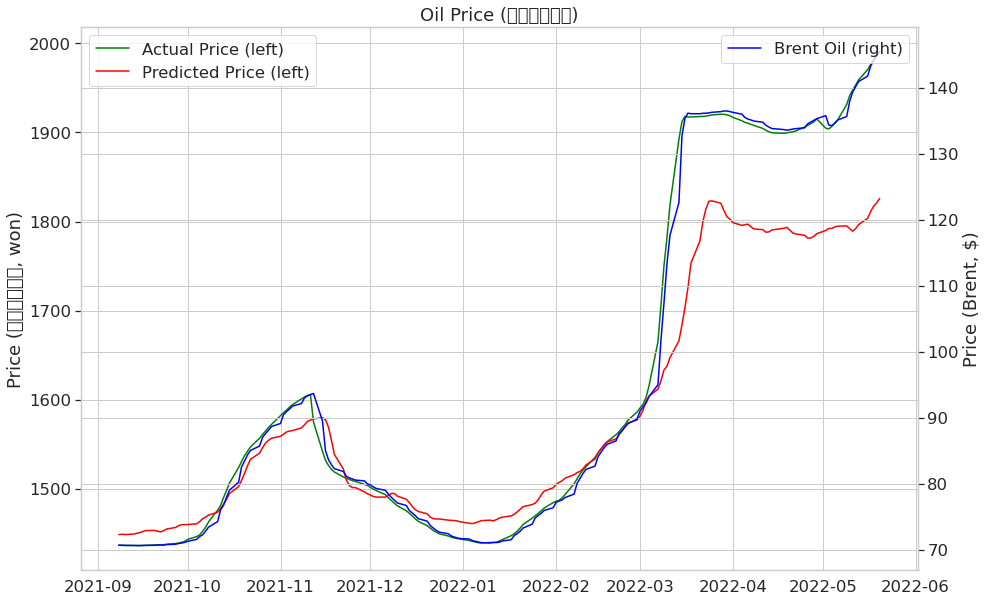

In [42]:
# Prediction
def draw_plot_test(model, df, X_test, y_test, scaler):
    y_hat = model.predict(X_test)

    y_test_ = [y[0] for y in y_test]
    y_hat = [y[0] for y in y_hat]
    X_test=X_test[:,:,1]
    y_test_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_test[:,-1], 
        df.columns[1]: y_test_}
        ))
    y_hat_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_test[:,-1], 
        df.columns[1]: y_hat}
        ))

    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax1.plot(total_dataset.iloc[-len(X_test):, 0], y_test_inverse[:, 1], label="Actual Price (left)", color='green')
    ax1.plot(total_dataset.iloc[-len(X_test):, 0], y_hat_inverse[:, 1], label="Predicted Price (left)", color='red')
    ax1.set_ylabel(f'Price ({df.columns[1]}, won)')

    ax2 = ax1.twinx()
    ax2.plot(total_dataset.iloc[-len(X_test):, 0], y_test_inverse[:, 0], label="Brent Oil (right)", color='blue')
    ax2.set_ylabel(f'Price (Brent, $)')

    plt.title(f'Oil Price ({df.columns[1]})')
    plt.xlabel('Time [days]')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()
    
draw_plot_test(model, df1, X_test, y_test, scaler1)

#print(X_test[:,:,1].shape)
#print(y_test.shape)

[1657.07489952 1665.13339017 1672.31338498 ... 1817.08822078 1820.89770323
 1825.84878574]


/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fi

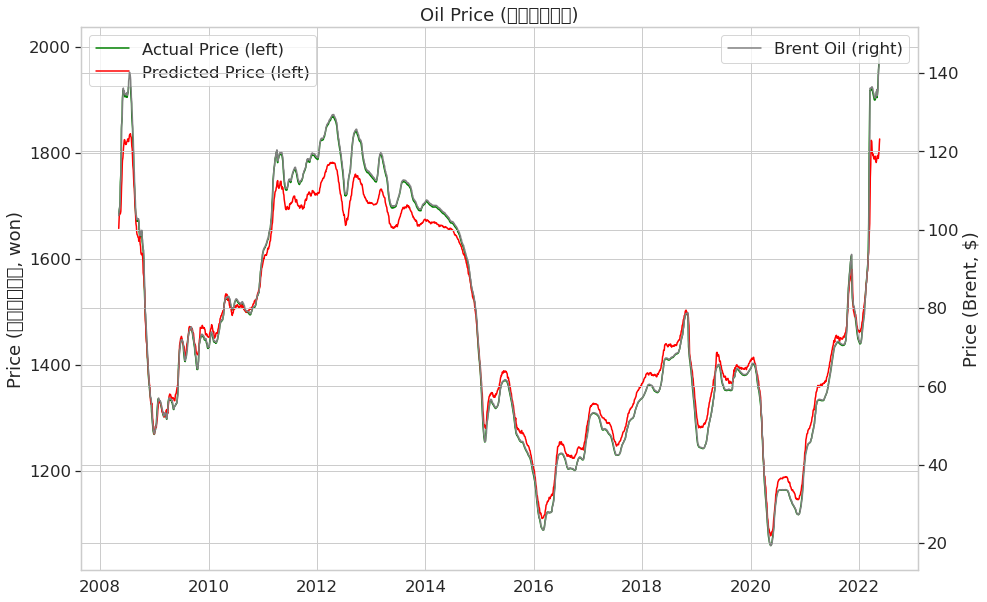

(3628, 14, 2)


In [45]:
def draw_plot_total(model, df, X_total, y_total, scaler):
    y_total_hat = model.predict(X_total)

    y_total_ = [y[0] for y in y_total]
    y_total_hat = [y[0] for y in y_total_hat]
    X_total=X_total[:,:,1]
    y_test_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_total[:,-1], 
        df.columns[1]: y_total_}
        ))
    y_hat_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_total[:,-1], 
        df.columns[1]: y_total_hat}
        ))

    fig, ax1 = plt.subplots(figsize=(15, 10))
    print(y_hat_inverse[:, 1])
    ax1.plot(total_dataset.iloc[-len(X_total):, 0], y_test_inverse[:, 1], label="Actual Price (left)", color='green')
    
    
    
    ax1.plot(total_dataset.iloc[-len(X_total):, 0], y_hat_inverse[:, 1], label="Predicted Price (left)", color='red')
    ax1.set_ylabel(f'Price ({df.columns[1]}, won)')

    ax2 = ax1.twinx()
    ax2.plot(total_dataset.iloc[-len(X_total):, 0], y_test_inverse[:, 0], label="Brent Oil (right)", color='grey')
    ax2.set_ylabel(f'Price (Brent, $)')

    plt.title(f'Oil Price ({df.columns[1]})')
    plt.xlabel('Time [days]')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

X_total = np.concatenate([X_train, X_test])
y_total = np.concatenate([y_train, y_test])
draw_plot_total(model, df1, X_total, y_total, scaler1)

print(X_total.shape)

In [46]:
def mae(actual,predict):
    return np.mean(abs(actual-predict))

def RMSE(actual,predict):
    return np.sqrt(np.mean((actual-predict)**2))


In [47]:
mae(y_test,model.evaluate(X_test,y_test))

6/6 [==============================] - 0s 10ms/step - loss: 0.0065


0.5933495581976838

In [48]:
RMSE(y_test,model.evaluate(X_test,y_test))

6/6 [==============================] - 0s 10ms/step - loss: 0.0065


0.6288867575095631